In [92]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../') # path to bemcs

import bemcs
import bemcs.kernels_stress_displacement as kernels

# Elastic parameters
mu = 1
nu = 0.25

# function to create triple junction
def create_triplejunctiongeometry(x1,x2,y1,y2):
    elements = []
    element = {}
    for i in range(len(x1)):
        element["x1"] = x1[i]
        element["y1"] = y1[i]
        element["x2"] = x2[i]
        element["y2"] = y2[i]
        elements.append(element.copy())
    elements = bemcs.standardize_elements(elements)
    return elements

# Triple Junctions
In this notebook we discuss the approach to dealing with 3 fault elements meeting at a point aka a triple junction. In plate kinematics, we deal with triple junctions by imposing that the slip vector at the triple junction is a conserved vector quantity i.e., 
$\begin{equation}
\underline{s}_1 + \underline{s}_2 + \underline{s}_3 = 0
\end{equation}$

Note in the above equation the sign of the slip vector depends on the circulation and directions of the unit normal vectors to each fault element. Below we start by constructing a 3-fault triple junction. 

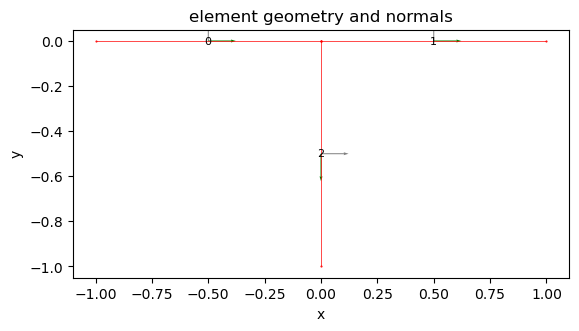

In [93]:
x1 = np.array((-1.,0,0))
x2 = np.array((0.,1.,0.))
y1 = np.array((0.,0.,0.))
y2 = np.array((0.,0.,-1.0))

elements = create_triplejunctiongeometry(x1,x2,y1,y2)
n_elements = len(elements)

plt.figure()
bemcs.plot_element_geometry(elements)
plt.show()

## Slip Vector

We specify the values of the slip vector here. These are important for the linear operator and boundary conditions that we need. 

In [94]:
# slip vector
slip_vector_x = np.array((1.0,0.8,-0.))
slip_vector_y = np.array((0.3,0.,-0.))

# Linear Operator and Boundary Conditions

For $N = 3$ elements, each having 3 nodes ($n_1,n_2,n_3$), we have $18$ equations. The linear operator that contains these equations itself has 4 different types of equations:
- Slip values (specified as either nodal or mean values) for the central node ($n_2$) of every element
- Slip values for the open nodes ($n_1$ or $n_3$) is set to $0$. The open nodes in this system are $p_1(n_1),p_2(n_3),p_3(n_3)$.
- Continuity of slip at a triple junction 
- Smoothness of slip between any 2 elements that share a common node (this is questionable)

1. p<sub>1</sub>(n<sub>1</sub>)<sub>x</sub> = 0 (open node)
2. p<sub>1</sub>(n<sub>1</sub>)<sub>y</sub> = 0 (open node)
3. p<sub>1</sub>(n<sub>2</sub>)<sub>x</sub> = $(u_1)_x$ (central node)
4. p<sub>1</sub>(n<sub>2</sub>)<sub>y</sub> = $(u_1)_y$ (central node)
5. p<sub>1</sub>(n<sub>3</sub>)<sub>x</sub> - p<sub>2</sub>(n<sub>1</sub>)<sub>x </sub> - p<sub>3</sub>(n<sub>1</sub>)<sub>x </sub>  = 0 (continuity of slip at a triple junction)
6. p<sub>1</sub>(n<sub>3</sub>)<sub>y</sub> - p<sub>2</sub>(n<sub>1</sub>)<sub>y </sub> - p<sub>3</sub>(n<sub>1</sub>)<sub>y </sub>  = 0 (continuity of slip at a triple junction)
7. p<sub>1</sub>(n<sub>3</sub>)grad<sub>x</sub> - p<sub>2</sub>(n<sub>1</sub>)grad<sub>x</sub> = 0 (smoothness)
8. p<sub>1</sub>(n<sub>3</sub>)grad<sub>y</sub> - p<sub>2</sub>(n<sub>1</sub>)grad<sub>y</sub> = 0(smoothness)
9. p<sub>2</sub>(n<sub>2</sub>)<sub>x</sub> = $(u_2)_x$ (central node)
10. p<sub>2</sub>(n<sub>2</sub>)<sub>y</sub> = $(u_2)_y$ (central node)
11. p<sub>2</sub>(n<sub>3</sub>)<sub>x</sub> = 0 (open node)
12. p<sub>2</sub>(n<sub>3</sub>)<sub>y</sub> = 0 (open node)
13. p<sub>1</sub>(n<sub>3</sub>)grad<sub>x</sub> - p<sub>3</sub>(n<sub>1</sub>)grad<sub>x</sub> = 0 (smoothness)
14. p<sub>1</sub>(n<sub>3</sub>)grad<sub>y</sub> - p<sub>3</sub>(n<sub>1</sub>)grad<sub>y</sub> = 0 (smoothness)
15. p<sub>3</sub>(n<sub>2</sub>)<sub>x</sub> = $(u_3)_x$ (central node)
16. p<sub>3</sub>(n<sub>2</sub>)<sub>y</sub> = $(u_3)_y$ (central node)
17. p<sub>3</sub>(n<sub>3</sub>)<sub>x</sub> = 0 (open node)
18. p<sub>3</sub>(n<sub>3</sub>)<sub>y</sub> = 0 (open node)

An alternate formulation may exist where we impose continuity and smoothness of slip in terms of triple junction kinematics.
- p<sub>1</sub>(n<sub>3</sub>)<sub>x</sub> - p<sub>2</sub>(n<sub>1</sub>)<sub>x </sub> - p<sub>3</sub>(n<sub>1</sub>)<sub>x </sub>  = 0 (continuity of slip at a triple junction)
- p<sub>1</sub>(n<sub>3</sub>)<sub>y</sub> - p<sub>2</sub>(n<sub>1</sub>)<sub>y </sub> - p<sub>3</sub>(n<sub>1</sub>)<sub>y </sub>  = 0 (continuity of slip at a triple junction)
- p<sub>1</sub>(n<sub>3</sub>)grad<sub>x</sub> - p<sub>2</sub>(n<sub>1</sub>)grad<sub>x</sub> - p<sub>3</sub>(n<sub>1</sub>)grad<sub>x</sub> = 0 (smoothness)
- p<sub>1</sub>(n<sub>3</sub>)grad<sub>y</sub> - p<sub>2</sub>(n<sub>1</sub>)grad<sub>y</sub> - p<sub>3</sub>(n<sub>1</sub>)grad<sub>y</sub> = 0 (smoothness)

This formulation appears rather attractive because in the limiting case that $\underline{s}_2 = 0$ or $\underline{s}_3 = 0$, these conditions would return the same solution as if there were only 2 fault elements. In contrast, the smoothness condition that we have currently applied force the gradient between any 2 pairs of elements to be equal. However, the alternate formulation is underdetermined and when solved with pseudo-inverse produces clear singular stresses at the triple junction. What we need is $2$ more equations that remove singularities and make the linear operator a square matrix!


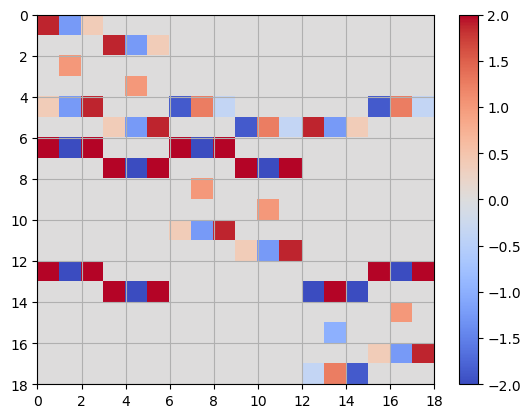

Linear Operator Condition Number: 33.11109567411942
[[ 4.17283951e-01  1.37037037e-01]
 [ 1.00000000e+00  3.00000000e-01]
 [ 1.24691358e+00  3.14814815e-01]
 [ 1.08641975e+00  7.40740741e-02]
 [ 8.00000000e-01 -1.38777878e-17]
 [ 3.16049383e-01 -1.48148148e-02]
 [-7.40740741e-02  4.93827160e-02]
 [ 0.00000000e+00  0.00000000e+00]
 [ 1.48148148e-02 -9.87654321e-03]]


In [95]:
# design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip,matrix_slipgradient = kernels.get_designmatrix_xy_3qn(elements,flag="node")
matrix_slip_mean,_ = kernels.get_designmatrix_xy_3qn(elements,flag="mean")

Nequations = len(elements)*6 
Nunknowns = len(elements)*6

matrix_system = np.zeros((Nequations,Nunknowns))

BCvector = np.zeros((Nequations,1))
BCvector[2::6] = slip_vector_x.reshape((-1,1))
BCvector[3::6] = slip_vector_y.reshape((-1,1))

# Linear operator for BCs as a matrix
# boundary nodes (set to 0 slip)
matrix_system[0:2,:] = matrix_slip[0:2:] # first element open node
matrix_system[10:12,:] = matrix_slip[10:12:] # second element open node
matrix_system[16:18,:] = matrix_slip[16:18,:] # last element open node

# patch center nodes (for x,y components)
matrix_system[2::6,:] = matrix_slip[2::6,:] # x component
matrix_system[3::6,:] = matrix_slip[3::6,:] # y component

# overlapping interior nodes (apply slip continuity and smoothness)
# triple junction equation of continuity
matrix_system[4,:] = matrix_slip[4,:] - matrix_slip[6,:] - matrix_slip[12,:]# x component
matrix_system[5,:] = matrix_slip[5,:] - matrix_slip[7,:] - matrix_slip[13,:]# y component

# smoothness (applied 2 elements at a time)
matrix_system[6,:] = matrix_slipgradient[4,:] - matrix_slipgradient[6,:]
matrix_system[7,:] = matrix_slipgradient[5,:] - matrix_slipgradient[7,:]
matrix_system[12,:] = matrix_slipgradient[4,:] - matrix_slipgradient[12,:]
matrix_system[13,:] = matrix_slipgradient[5,:] - matrix_slipgradient[13,:]

# plot design matrix
_,ax = plt.subplots()
pc = ax.pcolor(matrix_system,cmap="coolwarm",shading='flat')
ax.grid(which='both')
ax.invert_yaxis()
pc.set_clim(-2,2)
plt.colorbar(pc)
plt.show()

# Solve the system
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((len(elements)*3,1))
quadratic_coefs_n = np.zeros((len(elements)*3,1))
for i in range(len(elements)):
    quadratic_coefs_s[3*i:3*(i+1)] = quadratic_coefs[6*i:6*i+3]
    quadratic_coefs_n[3*i:3*(i+1)] = quadratic_coefs[6*i+3:6*(i+1)]
print(np.hstack((quadratic_coefs_s,quadratic_coefs_n)))

## Displacements and Stresses
After calculating stresses it is becoming apparent to me that the slip smoothness condition does not completely remove the singularity at the triple junction.

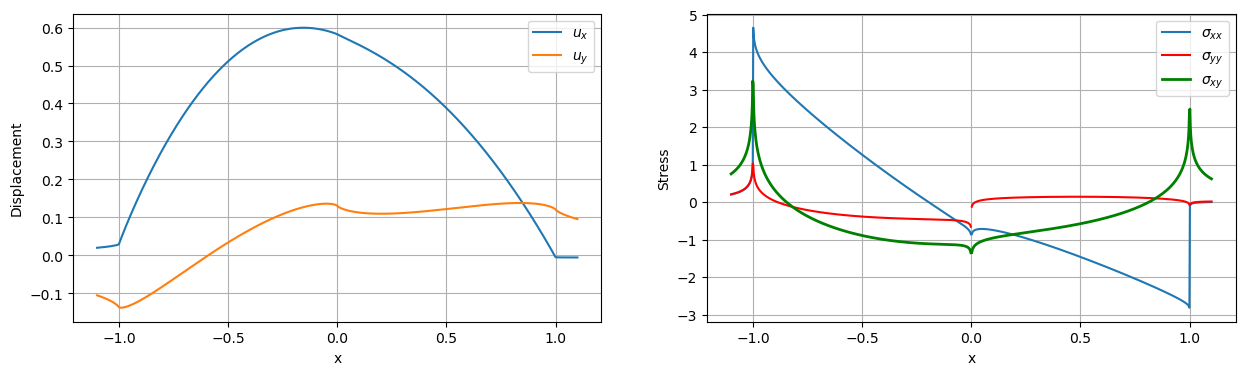

In [96]:
# Compute displacements along a line
x_obs = np.linspace(-1.1,1.1,1001).reshape(-1,1)
y_obs = 1e-8 + x_obs*0
# compute shear and tensile stress kernels
kernels_s = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,1)
kernels_n = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,0)
# compute displacement and stresses (we will plot it later)
ux = kernels_s[3] @ (quadratic_coefs_s) + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ (quadratic_coefs_s) + kernels_n[4] @ quadratic_coefs_n
sxx = kernels_s[0] @ (quadratic_coefs_s) + kernels_n[0] @ quadratic_coefs_n
syy = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(x_obs,ux,'-',label='$u_x$')
plt.plot(x_obs,uy,'-',label='$u_y$')
plt.grid()
plt.xlabel('x') 
plt.ylabel('Displacement')
plt.legend()
plt.subplot(1,2,2)
plt.plot(x_obs,sxx,'-',label='$\sigma_{xx}$')
plt.plot(x_obs,syy,'r-',label='$\sigma_{yy}$')
plt.plot(x_obs,sxy,'g-',label='$\sigma_{xy}$',linewidth=2)
plt.legend()
plt.grid()
plt.xlabel('x') 
plt.ylabel('Stress')
plt.show()

# Alternate formulation 

In this 'alternate' formulation, we create a linear operator using triple junction kinematic conditions for both slip and the gradient of slip. The resulting operator is underdetermined and we have to solve the system of equations using pseudo-inverse. The resulting stresses also appear singular.


1. p<sub>1</sub>(n<sub>1</sub>)<sub>x</sub> = 0 (open node)
2. p<sub>1</sub>(n<sub>1</sub>)<sub>y</sub> = 0 (open node)
3. p<sub>1</sub>(n<sub>2</sub>)<sub>x</sub> = $(u_1)_x$ (central node)
4. p<sub>1</sub>(n<sub>2</sub>)<sub>y</sub> = $(u_1)_y$ (central node)
5. p<sub>1</sub>(n<sub>3</sub>)<sub>x</sub> - p<sub>2</sub>(n<sub>1</sub>)<sub>x </sub> - p<sub>3</sub>(n<sub>1</sub>)<sub>x </sub>  = 0 (continuity of slip at a triple junction)
6. p<sub>1</sub>(n<sub>3</sub>)<sub>y</sub> - p<sub>2</sub>(n<sub>1</sub>)<sub>y </sub> - p<sub>3</sub>(n<sub>1</sub>)<sub>y </sub>  = 0 (continuity of slip at a triple junction)
7. p<sub>1</sub>(n<sub>3</sub>)grad<sub>x</sub> - p<sub>2</sub>(n<sub>1</sub>)grad<sub>x</sub> - p<sub>3</sub>(n<sub>1</sub>)grad<sub>x</sub> = 0 (smoothness at a triple junction)
8. p<sub>1</sub>(n<sub>3</sub>)grad<sub>y</sub> - p<sub>2</sub>(n<sub>1</sub>)grad<sub>y</sub> - p<sub>3</sub>(n<sub>1</sub>)grad<sub>y</sub> = 0 (smoothness at a triple junction)
9. p<sub>2</sub>(n<sub>2</sub>)<sub>x</sub> = $(u_2)_x$ (central node)
10. p<sub>2</sub>(n<sub>2</sub>)<sub>y</sub> = $(u_2)_y$ (central node)
11. p<sub>2</sub>(n<sub>3</sub>)<sub>x</sub> = 0 (open node)
12. p<sub>2</sub>(n<sub>3</sub>)<sub>y</sub> = 0 (open node)
13. 0 0 0 0 ........
14. 0 0 0 0 ........
15. p<sub>3</sub>(n<sub>2</sub>)<sub>x</sub> = $(u_3)_x$ (central node)
16. p<sub>3</sub>(n<sub>2</sub>)<sub>y</sub> = $(u_3)_y$ (central node)
17. p<sub>3</sub>(n<sub>3</sub>)<sub>x</sub> = 0 (open node)
18. p<sub>3</sub>(n<sub>3</sub>)<sub>y</sub> = 0 (open node)

[[ 4.22222222e-01  1.44444444e-01]
 [ 1.00000000e+00  3.00000000e-01]
 [ 1.22222222e+00  2.77777778e-01]
 [ 6.06837607e-01  5.55555556e-02]
 [ 8.00000000e-01 -1.95101878e-16]
 [ 4.11965812e-01 -1.11111111e-02]
 [-5.55555556e-02  5.04273504e-01]
 [-7.57642148e-17  6.06941710e-16]
 [ 1.11111111e-02 -1.00854701e-01]]


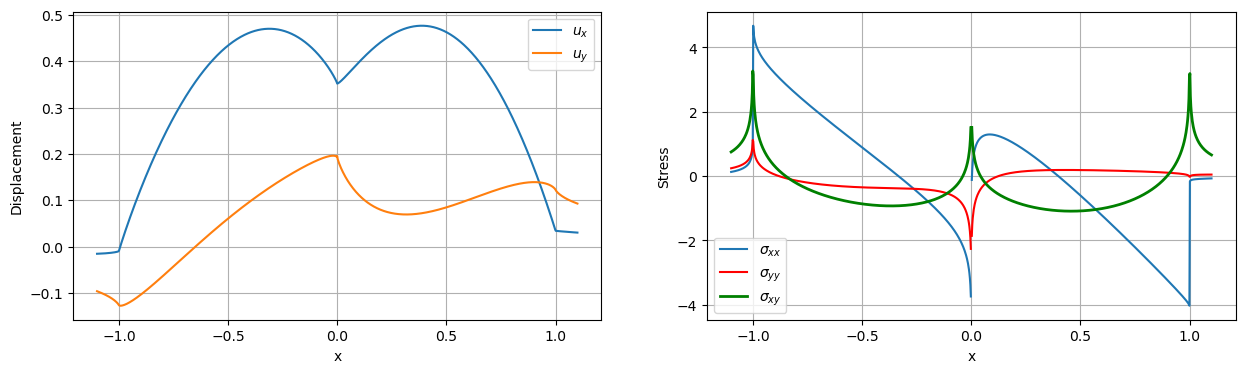

In [97]:
matrix_system = np.zeros((Nequations,Nunknowns))

BCvector = np.zeros((Nequations,1))
BCvector[2::6] = slip_vector_x.reshape((-1,1))
BCvector[3::6] = slip_vector_y.reshape((-1,1))

# Linear operator for BCs as a matrix
# boundary nodes (set to 0 slip)
matrix_system[0:2,:] = matrix_slip[0:2:] # first element open node
matrix_system[10:12,:] = matrix_slip[10:12:] # second element open node
matrix_system[16:18,:] = matrix_slip[16:18,:] # last element open node

# patch center nodes (for x,y components)
matrix_system[2::6,:] = matrix_slip[2::6,:] # x component
matrix_system[3::6,:] = matrix_slip[3::6,:] # y component

# overlapping interior nodes (apply slip continuity and smoothness)
# triple junction equation of continuity
matrix_system[4,:] = matrix_slip[4,:] - matrix_slip[6,:] - matrix_slip[12,:]# x component
matrix_system[5,:] = matrix_slip[5,:] - matrix_slip[7,:] - matrix_slip[13,:]# y component

# triple junction equation of smoothness 
matrix_system[6,:] = matrix_slipgradient[4,:] - matrix_slipgradient[6,:] - matrix_slipgradient[12,:]
matrix_system[7,:] = matrix_slipgradient[5,:] - matrix_slipgradient[7,:] - matrix_slipgradient[13,:]

# Solve the system
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.pinv(matrix_system) @ BCvector

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((len(elements)*3,1))
quadratic_coefs_n = np.zeros((len(elements)*3,1))
for i in range(len(elements)):
    quadratic_coefs_s[3*i:3*(i+1)] = quadratic_coefs[6*i:6*i+3]
    quadratic_coefs_n[3*i:3*(i+1)] = quadratic_coefs[6*i+3:6*(i+1)]
print(np.hstack((quadratic_coefs_s,quadratic_coefs_n)))

# compute displacement and stresses (we will plot it later)
ux = kernels_s[3] @ (quadratic_coefs_s) + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ (quadratic_coefs_s) + kernels_n[4] @ quadratic_coefs_n
sxx = kernels_s[0] @ (quadratic_coefs_s) + kernels_n[0] @ quadratic_coefs_n
syy = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(x_obs,ux,'-',label='$u_x$')
plt.plot(x_obs,uy,'-',label='$u_y$')
plt.grid()
plt.xlabel('x') 
plt.ylabel('Displacement')
plt.legend()
plt.subplot(1,2,2)
plt.plot(x_obs,sxx,'-',label='$\sigma_{xx}$')
plt.plot(x_obs,syy,'r-',label='$\sigma_{yy}$')
plt.plot(x_obs,sxy,'g-',label='$\sigma_{xy}$',linewidth=2)
plt.legend()
plt.grid()
plt.xlabel('x') 
plt.ylabel('Stress')
plt.show()